# Experiment reproduction

In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
    print('CUDA Visible devices:', os.getenv('CUDA_VISIBLE_DEVICES'))
else:
    device = torch.device('cpu')
    print("Failed to find GPU, using CPU instead.")

import torchvision
import torchmetrics
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(0)

Using GPU: Quadro RTX 8000
CUDA Visible devices: 3


# Dataset

We will work with the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. If we visit the website, we can find a good description of the dataset:

>The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
> The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Thankfully, we can load the data directly from torchvision API. First, lets define the torchvision transformations we want for our data.

In [2]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5)
])

Now load the data using those transformations

In [3]:
train_data = torchvision.datasets.CIFAR10(
    root="datasets/", train=True, download=True, transform=train_transforms
)
test_data = torchvision.datasets.CIFAR10(
    root="datasets/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

# Create a dictionary to map the class indices to the class names.
class_map = {i: cls for i, cls in enumerate(train_data.classes)}
class_map

Files already downloaded and verified
Files already downloaded and verified


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Put the train and test data into dataloaders

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Take a look at the images from our train dataloader

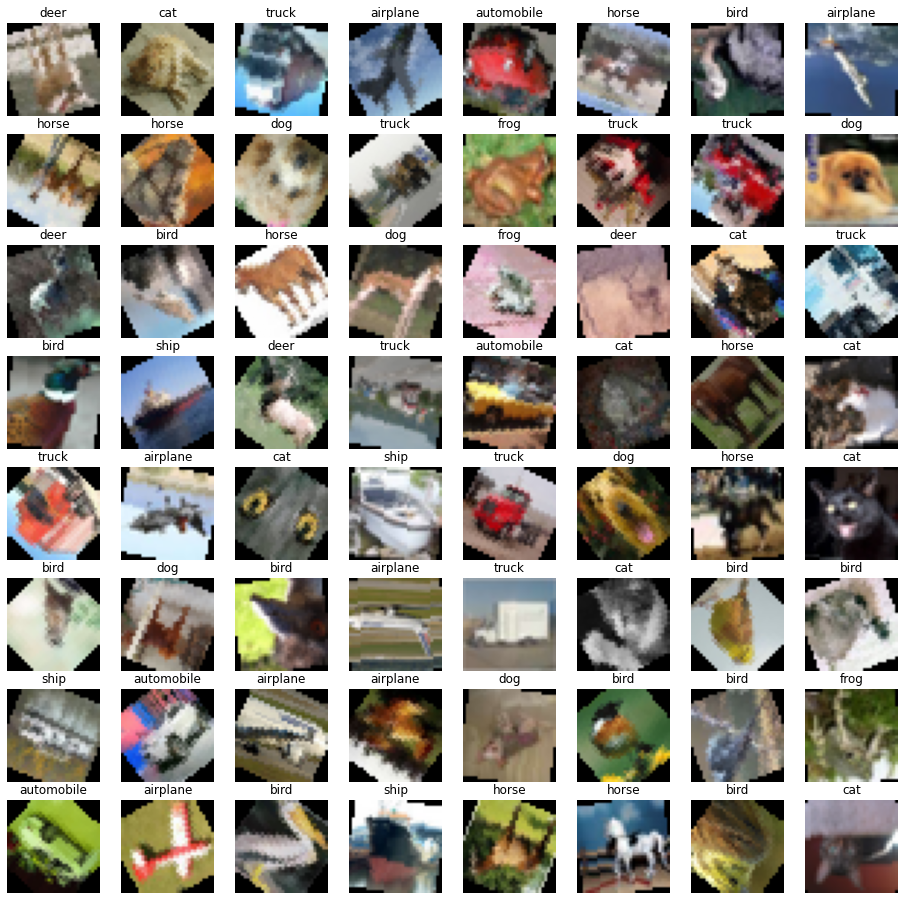

In [5]:
train_images, train_labels = next(iter(train_dataloader))
fig, axs = plt.subplots(8, 8, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    ax.imshow(train_images[i].permute(1, 2, 0))
    ax.set_title(class_map[train_labels[i].item()])
    ax.axis("off")

# Model

Lets create a simple ResNet model. We will start with the basic computation block. For this, we want to use blocks consisting of `Conv, Batchnorm and ReLU`

In [6]:
class Block(nn.Module):
    def __init__(self, dim, dim_out):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.BatchNorm2d(dim_out)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = self.act(x)
        return x

Now we will build our residual block on top of the base block. For each residual block, two base blocks will be used.

In [7]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out):
        super().__init__()
        self.block1 = Block(dim, dim_out)
        self.block2 = Block(dim_out, dim_out)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x):
        h = self.block1(x)
        h = self.block2(h)
        return h + self.res_conv(x)

Finally, because our classification task is very simple, we want a small model with three residual blocks.

In [8]:
class Resnet(nn.Module):
    def __init__(self, filters, num_classes=10):
        super().__init__()

        self.res_blocks = nn.ModuleList()
        for in_dim, out_dim in zip(filters[:-1], filters[1:]):
            self.res_blocks.append(ResnetBlock(in_dim, out_dim))

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(filters[-1], num_classes)
    
    def forward(self, x):
        for res_block in self.res_blocks:
            x = res_block(x)
            x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Create the model and see if it is able to take our sample train batch as input

In [9]:
model = Resnet([3, 64, 128, 256, 512, 1024])
model(train_images).shape

torch.Size([64, 10])

# Run

## Utility functions

Lets first declare a pair of functions for making the code clearer in the main script

In [10]:
def dict_to_str(dict_):
    """Creates a string out of dictionary keys and values."""
    return ', '.join(f'{key.lower()}: {value:.4f}' for key, value in dict_.items())


def exists(obj):
    """Checks if `obj` is not None."""
    return obj is not None

Now define the main script

In [11]:
def run(
  model, 
  optimizer, 
  loss_fn, 
  train_dataloader, 
  epochs,
  valid_dataloader=None, 
  metrics=None,
  log_dir=None,
  log_freq=10_000,
):
    
    model.to(device)
    size = len(train_dataloader.dataset)

    train_loss_tracker = torchmetrics.MeanMetric().to(device)
    if exists(metrics):
        metrics = torchmetrics.MetricCollection(metrics).to(device)
        train_metrics = metrics.clone(prefix='train_')
    if exists(log_dir):
        train_log_dir = os.path.join(log_dir, 'train')
        train_writer = SummaryWriter(log_dir=train_log_dir)
    
    if exists(valid_dataloader):
        valid_loss_tracker = torchmetrics.MeanMetric().to(device)
        if exists(metrics):
            valid_metrics = metrics.clone(prefix='val_').to(device)
        if exists(log_dir):
            valid_log_dir = os.path.join(log_dir, 'valid')
            valid_writer = SummaryWriter(log_dir=valid_log_dir)
    
    for epoch in range(epochs):
        model.train()
        for batch_id, (images, targets) in enumerate(train_dataloader):
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            train_loss = loss_fn(logits, targets)
            train_loss_tracker.update(train_loss)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            probs = torch.softmax(logits, dim=1)
            metrics_output = train_metrics(probs, targets)

            if log_freq > 0:
                if batch_id % log_freq == 0:
                    train_loss, current_sample = train_loss.item(), batch_id*len(images)
                    train_summary = f"train_loss: {train_loss:.4f}, " + dict_to_str(metrics_output)
                    print(f"[{current_sample:>5d}/{size:>5d}] -> {train_summary}")

        # Training ends: compute metrics for the epoch.
        epoch_loss = train_loss_tracker.compute()
        epoch_metrics = train_metrics.compute()
        train_summary = f"train_loss: {epoch_loss:.4f}, " + dict_to_str(epoch_metrics)
        print(f"Epoch {epoch + 1}/{epochs} -> {train_summary}", end="")
        if exists(log_dir):
            train_writer.add_scalar('loss', epoch_loss, global_step=epoch)
            for key, value in epoch_metrics.items():
                train_writer.add_scalar(key[6:], value, global_step=epoch)

        if exists(valid_dataloader):
            model.eval()
            for batch_id, (images, targets) in enumerate(train_dataloader):
                with torch.no_grad():
                    images, targets = images.to(device), targets.to(device)
                    logits = model(images)
                    valid_loss = loss_fn(logits, targets)
                    valid_loss_tracker.update(valid_loss)
                    
                    probs = torch.softmax(logits, dim=1)
                    valid_metrics.update(probs, targets)
            
            epoch_loss = valid_loss_tracker.compute()
            epoch_metrics = valid_metrics.compute()
            valid_summary = f", val_loss: {epoch_loss:.4f}, " + dict_to_str(epoch_metrics)
            if exists(log_dir):
                valid_writer.add_scalar('loss', epoch_loss, global_step=epoch)
                for key, value in epoch_metrics.items():
                    valid_writer.add_scalar(key[4:], value, global_step=epoch)
            print(valid_summary)

        # Reset metrics.
        train_metrics.reset()
        train_loss_tracker.reset()
        if exists(valid_dataloader):
            valid_metrics.reset()
            valid_loss_tracker.reset()

# Execution

Start by declaring the loss, optimizer and metrics that will help on the model training

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics_args = dict(num_classes=10, threshold=0.5)
metrics = [
    torchmetrics.Accuracy(**metrics_args), 
    torchmetrics.Precision(**metrics_args),
    torchmetrics.Recall(**metrics_args),
    torchmetrics.F1Score(**metrics_args),
]

Execute the run function. If you defined a `log_dir`, make sure to take a look at Tensorboard.

In [13]:
run(
    model, 
    optimizer, 
    loss_fn, 
    train_dataloader, 
    epochs=10, 
    valid_dataloader=test_dataloader, 
    metrics=metrics, 
    log_freq=0,
    log_dir="experiment_reproduction/000-first_run",
)

Epoch 1/10 -> train_loss: 1.8330, train_accuracy: 0.3219, train_precision: 0.3219, train_recall: 0.3219, train_f1score: 0.3219, val_loss: 2.2008, val_accuracy: 0.2552, val_precision: 0.2552, val_recall: 0.2552, val_f1score: 0.2552
Epoch 2/10 -> train_loss: 1.6392, train_accuracy: 0.3971, train_precision: 0.3971, train_recall: 0.3971, train_f1score: 0.3971, val_loss: 1.7964, val_accuracy: 0.3579, val_precision: 0.3579, val_recall: 0.3579, val_f1score: 0.3579
Epoch 3/10 -> train_loss: 1.5399, train_accuracy: 0.4403, train_precision: 0.4403, train_recall: 0.4403, train_f1score: 0.4403, val_loss: 1.7616, val_accuracy: 0.3775, val_precision: 0.3775, val_recall: 0.3775, val_f1score: 0.3775
Epoch 4/10 -> train_loss: 1.4757, train_accuracy: 0.4645, train_precision: 0.4645, train_recall: 0.4645, train_f1score: 0.4645, val_loss: 1.7204, val_accuracy: 0.4034, val_precision: 0.4034, val_recall: 0.4034, val_f1score: 0.4034
Epoch 5/10 -> train_loss: 1.4282, train_accuracy: 0.4806, train_precision: 0